# Generative models

-- Prof. Dorien Herremans

# Variational Autoencoders (VAEs)



In this section we will be disecting a VAE code in PyTorch. 

The VAE implemented here uses the setup found in most VAE papers: a multivariate Normal distribution for the conditional distribution of the latent vectors given and input image ($q_{\phi}(z | x_i)$ in the slides) and a multivariate Bernoulli distribution for the conditional distribution of images given the latent vector ($p_{\theta}(x | z)$ in the slides). Using a Bernoulli distribution, the reconstruction loss (negative log likelihood of a data point in the output distribution) reduces to the pixel-wise binary cross-entropy. See the [original VAE paper](https://arxiv.org/pdf/1312.6114.pdf and [reference code](https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb)), for details.

As usualy we load the required libraries first...

In [ ]:
import torchvision
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

## Parameter Settings

We define some parameters. Doing it separate of the actual code allows us to play around with them and setup an experiment more easily. 

In [ ]:
# 2-d latent space, parameter count in same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)
latent_dims = 2
num_epochs = 100
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True


## MNIST Data Loading

We've used the FashionMNIST dataset before, but here we are going to take a look at the simple original MNIST dataset. 

MNIST images show digits from 0-9 in 28x28 grayscale images. We do not center them at 0, because we will be using a binary cross-entropy loss that treats pixel values as probabilities in [0,1]. We create both a training set and a test set.

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## VAE Definition

We use a convolutional encoder and decoder, which generally gives better performance than fully connected versions that have the same number of parameters.

In convolution layers, we increase the feature map channels as we approach the bottleneck, but note that the total number of features still decreases, since the channels increase by a factor of 2 in each convolution, but the spatial size decreases by a factor of 4.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

We'll first describe the encoder... The noticeable thing here is that the latent variables $z$ (those resulting after the encoder are mean (mu) and st.dev (logvar) of standard distributions, from which we will later sample. Hence, use $x$ after the second convolution layer to generate both these latent variables. This is not done sequentially, but both on the same $x$. 

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        # notice, here we use use x for mu and for variance! 
        x_mu = self.fc_mu(x) 
        x_logvar = self.fc_logvar(x) #we don't calculate this from x_mu but from x!! This is crutial. 
        return x_mu, x_logvar

Followed by defining the decoder...

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x   


Now the actual model combines both the encoder and the decoder, and combines them by adding sampling in between. Remember how latent variables in VAE are in fact the mean and std. dev of gaussian distributions? We will make sure the output of the encoder fits this and then sample from this output using a function that generates a normal distributed torch tensor: torch.empty_like(std).normal_().

Notice that we also implement the VAE using the reparametrization trick we talked about in the lecture. This enables us to perform backpropagation, even though we perform sampling. 

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        # remember our encoder output consists of x_mu and x_logvar
        latent_mu, latent_logvar = self.encoder(x)
        # we sample from the distributions defined by mu and logvar
        # (function latent_sample defined below)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_() #define normal distribution
            return eps.mul(std).add_(mu) #sample from normal distribution
        else:
            return mu

We saw in the lecture that VAE loss consists of different components. On the one hand we have the reconstruction loss which is based on the reconstruction loss (distance or binary cross entropy); and on the other hand we have the KL divergence between the two distributions: 

$L = L(x,\hat{x} )+\sum_j KL(q_j(z|x)||p(z))$

In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence
    
    
vae = VariationalAutoencoder()

Like before, we move the model to the GPU. 

Now let's check how many parameters the model has (i.e. how many parameters we need to learn during training): 

In [ ]:
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 308357


## Train VAE

We are now ready to train our model. We use the typicaly Adam optimizer and train in batches. Pretty standard as we saw in the previous labs. 

In [ ]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 100] average reconstruction error: 23941.125875
Epoch [2 / 100] average reconstruction error: 21110.019252
Epoch [3 / 100] average reconstruction error: 20528.183300
Epoch [4 / 100] average reconstruction error: 20243.432446
Epoch [5 / 100] average reconstruction error: 20068.160106
Epoch [6 / 100] average reconstruction error: 19942.596794
Epoch [7 / 100] average reconstruction error: 19826.917792
Epoch [8 / 100] average reconstruction error: 19746.438023
Epoch [9 / 100] average reconstruction error: 19669.005976
Epoch [10 / 100] average reconstruction error: 19599.894165
Epoch [11 / 100] average reconstruction error: 19553.592846
Epoch [12 / 100] average reconstruction error: 19500.354190
Epoch [13 / 100] average reconstruction error: 19469.007533
Epoch [14 / 100] average reconstruction error: 19401.241115
Epoch [15 / 100] average reconstruction error: 19380.922029
Epoch [16 / 100] average reconstruction error: 19336.156910
Epoch [17 / 100] average reconstruct

## Plot Training Curve

Does the training go well? We can visualise the evolution of the training loss.

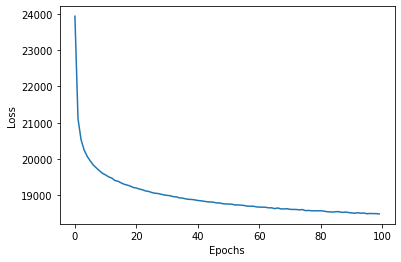

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Alternatively: Load Pre-Trained VAE

Great, so now we have trained a VAE. The power of such unsupervised models is that we can yet again apply transfer learning: when we train our model on a much larger dataset, we can use this pretrained model for a task of which we don't have so much data. The advantage is that we can: 
* save time training;
* leverage big data for which models can find patterns more easily.

In case the url below does not work, the file is also available at: https://dorax.s3.ap-south-1.amazonaws.com/vae_2d.pth

In [ ]:
filename = 'vae_2d.pth'
import urllib
if not os.path.isdir('./pretrained'):
    os.makedirs('./pretrained')
print('downloading ...')
# urllib.request.urlretrieve ("http://geometry.cs.ucl.ac.uk/creativeai/pretrained/"+filename, "./pretrained/"+filename)
urllib.request.urlretrieve ("https://dorax.s3.ap-south-1.amazonaws.com/"+filename, "./pretrained/"+filename)

vae.load_state_dict(torch.load('./pretrained/'+filename))
print('done')

# fyi this is how the VAE parameters can be saved:
# torch.save(vae.state_dict(), './pretrained/my_vae.pth')

downloading ...
done


## Evaluate on the Test Set
Now it's great that our training loss goes down, but to do proper evaluation and check if the model doesn't over/underfit, we need to evaluate on the test set loss. 


In [ ]:
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    with torch.no_grad():
    
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 19294.807163


## Visualize Reconstructions

So what can we do with this model? We can use the condition to generate images of particular letters. 

Original images


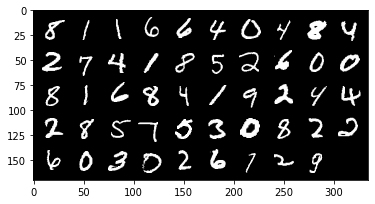

tensor([1, 8, 1, 1, 6, 6, 4, 0, 4, 8, 4, 2, 7, 4, 1, 8, 5, 2, 6, 0, 0, 8, 1, 6,
        8, 4, 1, 9, 2, 4, 4, 2, 8, 5, 7, 5, 3, 0, 8, 2, 2, 6, 0, 3, 0, 2, 6, 7,
        2, 9, 2, 4, 8, 8, 7, 5, 3, 3, 1, 7, 6, 6, 2, 2, 2, 5, 2, 1, 6, 4, 8, 1,
        3, 0, 7, 1, 8, 0, 6, 3, 7, 8, 5, 7, 0, 2, 8, 5, 0, 8, 0, 4, 2, 9, 2, 3,
        4, 3, 9, 5, 9, 9, 9, 8, 9, 0, 7, 1, 9, 6, 0, 2, 3, 9, 4, 6, 7, 8, 2, 3,
        3, 1, 1, 2, 4, 4, 3, 0])
VAE reconstruction:


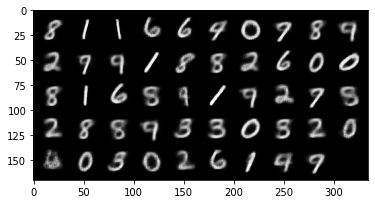

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        # fetch the generated images by calling the model: 
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()


# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

## Interpolate in Latent Space

Now let's do something fun. What happens if we take the encoder output (latent code) of 2 images, and interpolate it so that it gradually changes from image 1 to image 2. 

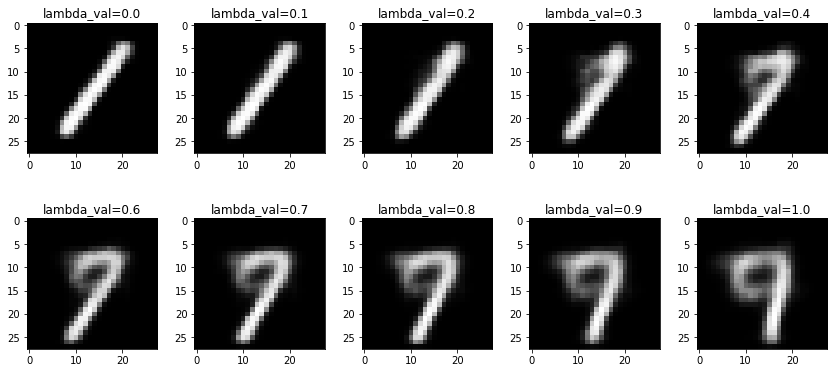

In [ ]:
vae.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        # this is the output of the encoder (z)
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        # we interpolate the z_1 to z_2 with out lambda1
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        # by sending it throug the decoder
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas, create an equally spaced range
lambda_range=np.linspace(0,1,10)

# setup the plot
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

# for each element in the range of lambda: 
for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae, digits[7][0], digits[1][0])
   
    # get the interpolated image
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
    
    # plot the interpolated image
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 

## Sample Latent Vector from Prior (VAE as Generator)

A VAE can generate new digits by drawing latent vectors from the prior distribution. Although the generated digits are not perfect, they are usually better than for a non-variational Autoencoder.

Similar to autoencoders, the manifold of latent vectors that decode to valid digits is sparser in higher-dimensional latent spaces. Increasing the weight of the KL-divergence term in the loss (increasing `variational_beta`) makes the manifold less sparse at the cost of a lower-quality reconstruction. 

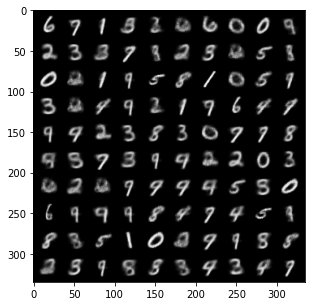

In [ ]:
vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, latent_dims, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

## Show 2D Latent Space
What does the latent space look like in our model? We will interpolate here to see what the $z$'s represent. We see that most number features are represented here... 

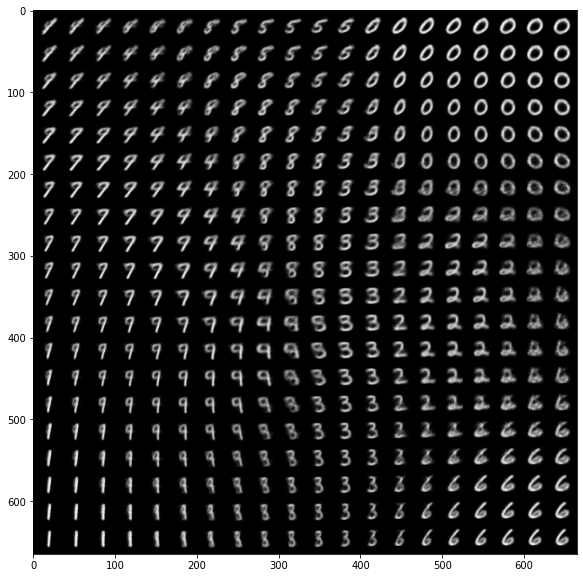

In [ ]:
# load a network that was trained with a 2d latent space
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')
    
with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()

# Conditional GAN (cGAN)

-- Dorien Herremans 
(inspired heavily by the references at the bottom)


Below is a PyTorch implementation of [Conditional GAN](https://arxiv.org/abs/1411.1784), which is a GAN that allows you to choose the label of the generated image. The generator and the discriminator are going to be simple feedforward networks, so the images won't be as good as in this [nice Kaggle kernel by Sergio Gámez](https://www.kaggle.com/sgamez/fashion-ac-gan-with-keras). This tutorial is based on [this post](https://www.kaggle.com/arturlacerda/pytorch-conditional-gan/notebook). 

Let's start by loading the required libraries. 

In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

Let's use the FashionMNIST dataset again like in the previous tutorials. 

In [ ]:
class FashionMNIST(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv('../input/fashion-mnist_train.csv')
        self.labels = fashion_df.label.values
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img, label

How does an entry in our dataset look like? 

Notice that we standardize the values like before. 

In [ ]:
from torchvision.datasets import FashionMNIST

#we load it much like in the previous CNN tutorial and standardize the values
transform = transforms.Compose([
        transforms.ToTensor(),transforms.Normalize(mean=(0.5), std=(0.5))
])

dataset = FashionMNIST(root = './data', train = True, transform = transform, download = True)
dataset[0][0]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

We create a dataloader with batch size 64 that shuffles our data. 

In [ ]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

Now let's define the generator and the discriminator, which are simple multilayer perceptron models with LeakyReLU activation. We are going to use an embedding layer for the label. We add dropout for regularization. 

Note that we concatenate the condition label c to the image x. 

In [ ]:
 class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # use an embedding layer for the layer
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        # concatenates x and c, so the condition is given as input to the model appended to the image x
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

Remeber 'squeeze'? This returns a tensor with all the dimensions of input of size 1 removed.

For example, if input is of shape: (A×1×B×C×1×D) then the out tensor will be of shape: (A×B×C×D) .


Now for our generator, we again define a fully connected network with LeakyReLU. Similar to before, we concatenate the condition (label) to the input latent variables. 

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1) # concatenates z and c, so the condition is given as input to the model appended to z
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

We move our model to cuda for faster processing. 

In [ ]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

We use Adam optimizer for both models and a binary cross entropy loss. 

In [ ]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)


During the generator training we try  to optimize the output of the discriminator (e.g. generate images that are optimized and not discriminable from real ones), i.e. we optimize the variable `validity' here. Discriminator weights are kept the same, only generator weights change.  


In [ ]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data


During discriminator training we first feed it a real example (directly from the dataset), then a take example (based on random noise $z$ sent through the generator). The loss function tries to match the former with a tensor of ones, and the latter with a tensor of zeros (= real-fake labels). 

In [ ]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    
    # train with fake images
    # generate random noise image
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    # feed the noise to the generator and get the output
    fake_images = generator(z, fake_labels)
    # evaluate this output
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    # optimize the sum of both losses
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data


Ok let's start our training. During each epoch, we will generate an image for each condition (label). 

Note that we train the generator and discriminator alternatingly. 

Starting epoch 0...
g_loss: 3.3613052368164062, d_loss: 0.36655232310295105


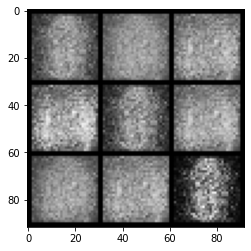

Starting epoch 1...
g_loss: 3.881035327911377, d_loss: 0.18214480578899384


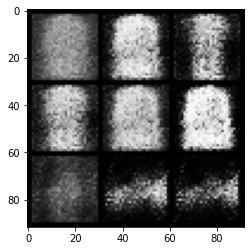

Starting epoch 2...
g_loss: 3.900115489959717, d_loss: 0.3044796586036682


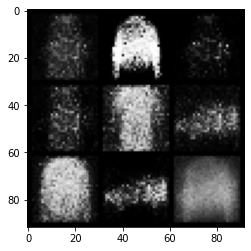

Starting epoch 3...
g_loss: 4.374887943267822, d_loss: 0.35884690284729004


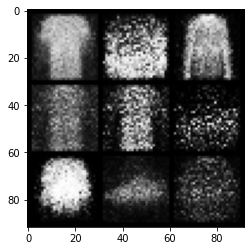

Starting epoch 4...
g_loss: 2.7533140182495117, d_loss: 0.4661397635936737


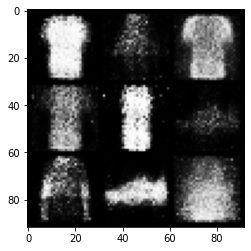

Starting epoch 5...
g_loss: 2.911227226257324, d_loss: 0.49421626329421997


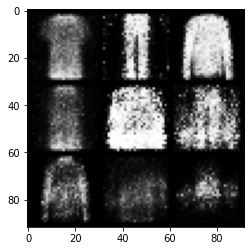

Starting epoch 6...
g_loss: 1.910022258758545, d_loss: 0.8912621736526489


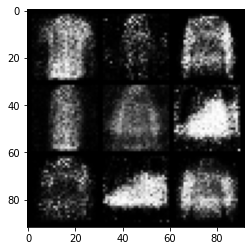

Starting epoch 7...
g_loss: 2.2481372356414795, d_loss: 0.5733170509338379


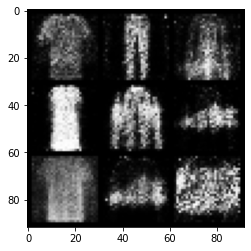

Starting epoch 8...
g_loss: 2.0611939430236816, d_loss: 0.7126811742782593


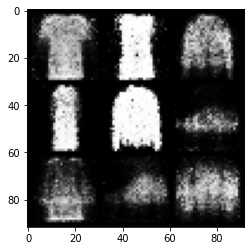

Starting epoch 9...
g_loss: 1.7753983736038208, d_loss: 0.5344954133033752


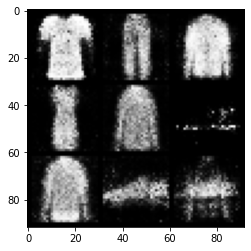

Starting epoch 10...
g_loss: 1.9311304092407227, d_loss: 0.7173724174499512


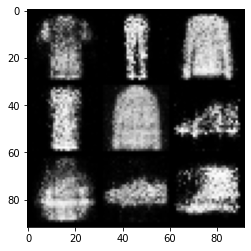

Starting epoch 11...
g_loss: 1.8142889738082886, d_loss: 0.6802242994308472


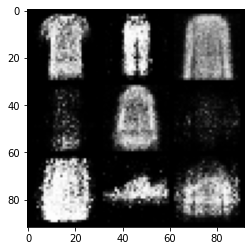

Starting epoch 12...
g_loss: 1.49580717086792, d_loss: 0.9825212955474854


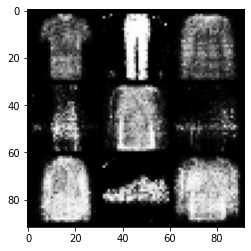

Starting epoch 13...
g_loss: 1.8522588014602661, d_loss: 0.7567787170410156


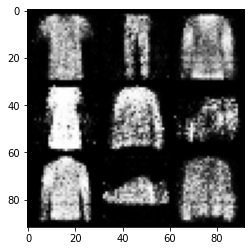

Starting epoch 14...
g_loss: 1.676206350326538, d_loss: 0.6099720597267151


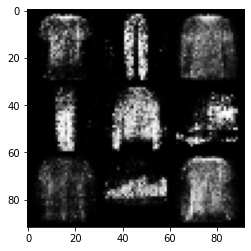

Starting epoch 15...
g_loss: 1.8242594003677368, d_loss: 0.7656724452972412


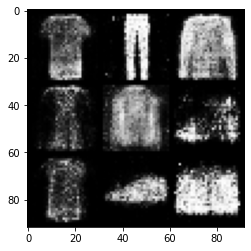

Starting epoch 16...
g_loss: 1.5616220235824585, d_loss: 0.7526279091835022


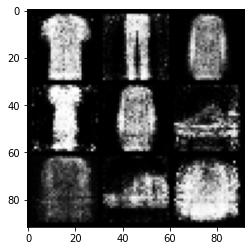

Starting epoch 17...
g_loss: 1.409250259399414, d_loss: 0.969147801399231


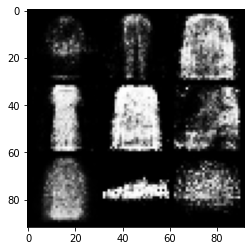

Starting epoch 18...
g_loss: 1.35406494140625, d_loss: 0.9689954519271851


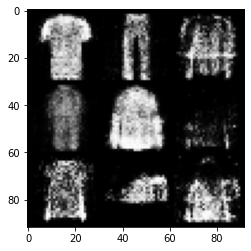

Starting epoch 19...
g_loss: 1.3831732273101807, d_loss: 0.6295530200004578


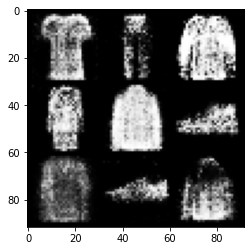

Starting epoch 20...
g_loss: 1.187748908996582, d_loss: 1.114561676979065


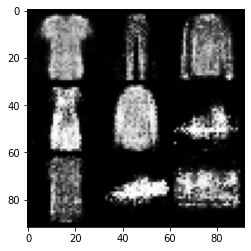

Starting epoch 21...
g_loss: 1.5228841304779053, d_loss: 1.083432674407959


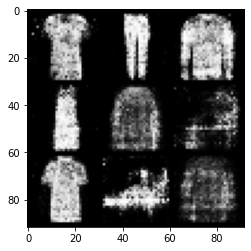

Starting epoch 22...
g_loss: 1.3908097743988037, d_loss: 0.930268406867981


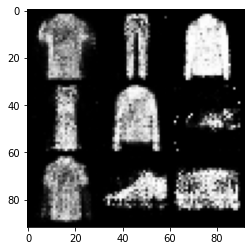

Starting epoch 23...
g_loss: 1.2019670009613037, d_loss: 0.9261369705200195


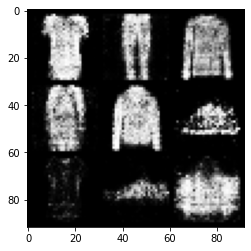

Starting epoch 24...
g_loss: 1.2052844762802124, d_loss: 1.1979503631591797


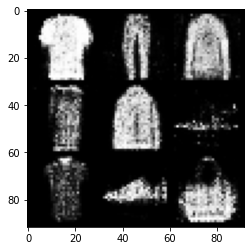

Starting epoch 25...
g_loss: 1.3105285167694092, d_loss: 0.8518480658531189


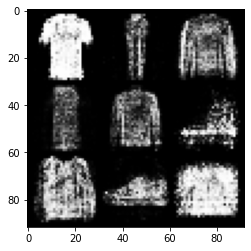

Starting epoch 26...
g_loss: 1.345018744468689, d_loss: 1.0331064462661743


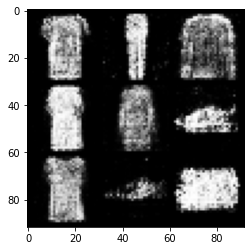

Starting epoch 27...
g_loss: 1.3003754615783691, d_loss: 0.9186596870422363


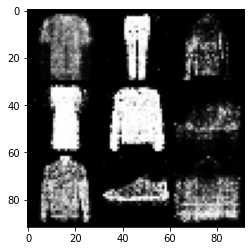

Starting epoch 28...
g_loss: 1.2770322561264038, d_loss: 1.0215826034545898


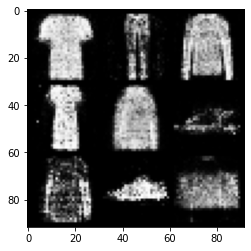

Starting epoch 29...
g_loss: 1.2262154817581177, d_loss: 0.9982607960700989


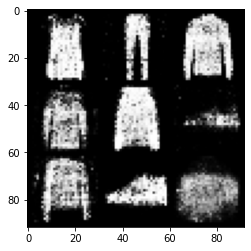

In [ ]:
num_epochs = 30
n_critic = 5
display_step = 300

# for each epoch
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        # train the generator
        generator.train()
        batch_size = real_images.size(0)
        # train the discriminator
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    # generate random noise to feed to the generator
    z = Variable(torch.randn(9, 100)).cuda()

    # get all the labels
    labels = Variable(torch.LongTensor(np.arange(9))).cuda()

    # generate a new mage for each of the labels based on the label and the noise z
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()

    # display the images
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

In [ ]:
print(labels)

tensor([1, 8, 1, 1, 6, 6, 4, 0, 4, 8, 4, 2, 7, 4, 1, 8, 5, 2, 6, 0, 0, 8, 1, 6,
        8, 4, 1, 9, 2, 4, 4, 2, 8, 5, 7, 5, 3, 0, 8, 2, 2, 6, 0, 3, 0, 2, 6, 7,
        2, 9, 2, 4, 8, 8, 7, 5, 3, 3, 1, 7, 6, 6, 2, 2, 2, 5, 2, 1, 6, 4, 8, 1,
        3, 0, 7, 1, 8, 0, 6, 3, 7, 8, 5, 7, 0, 2, 8, 5, 0, 8, 0, 4, 2, 9, 2, 3,
        4, 3, 9, 5, 9, 9, 9, 8, 9, 0, 7, 1, 9, 6, 0, 2, 3, 9, 4, 6, 7, 8, 2, 3,
        3, 1, 1, 2, 4, 4, 3, 0])


Amazing how, with each epoch, the generated images become better and better. I hope this code gives you insight into how two popular models (VAE and cGAN) work and inspires you to think of building a generative model yourself!

# Nice examples of different types of GANs

https://github.com/purelyvivid/pytorch-gan-in-one-notebook


## References
AE example https://github.com/ReyhaneAskari/pytorch_experiments/blob/master/AE.py

GAN example: https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py

https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py

https://github.com/ReyhaneAskari/pytorch_experiments/blob/master/AE.py

Pix2pix: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/pix2pix_model.py

https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

https://phillipi.github.io/pix2pix/

https://github.com/Lornatang/PyTorch/blob/master/official/gan/bicyclegan/models.py

https://www.kaggle.com/arturlacerda/pytorch-conditional-gan/